In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
from dotenv import load_dotenv
load_dotenv()
project_root = os.getenv("PROJECT_ROOT")
module_path = f"{project_root}/"
sys.path.insert(0, module_path)


In [2]:
import torch
import torch.nn.functional as F
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import seaborn as sns
import multiprocessing

from utils import *
from classes import *
sns.set_palette(sns.color_palette("deep"))
pl.seed_everything(42, workers=True)

from tqdm import  tqdm
import seaborn as sns
import pandas as pd



Global seed set to 42


In [3]:
benign_root = f"{project_root}/datasets/final_datasets/benign/full_size"
adv_root = f"{project_root}/datasets/final_datasets/adversarial"


nvp_load_root = f"{project_root}/weights/NVP/combined/nvp.pt"

## This needs to point to the root of the individual folder.
## The models should be arranged in the way:
## 0.pt = jpg_minpool_jpg
## 1.pt = maxpool
## 2.pt = minpool
## 3.pt = minpool_jpg

nvp_indiv_load_root = f"{project_root}/weights/NVP/individual"

In [4]:

dataset_batch_size=32

## Shuffles the datasets.
should_shuffle_datasets = True



## Needs to be scaled to support resnets dense layers, which require 224,224 image sizes
img_transforms = transforms.Compose([
    transforms.Lambda(lambda x:  F.interpolate(x.unsqueeze(0), size=(224, 224), mode='bilinear', align_corners=False, antialias=True).squeeze(0)),
    ])

## Returns an array and map of the classification labels, i.e. "inanimate".
int_labels, label_map = get_label_arr_and_map(
    torch_features=3
)


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [5]:
## This retrieves the benign and adversarial datasets and mixes them.
## The "should_return_class" and "should_return_attack_type" are used for metrics.
## The "should_truncate_datasets" truncates the benign dataset down to the size of the adversarial dataset, going from 150 000 to 60 000.
## The "num_workers" determines the number of workers used in each dataloader. Adjust this value if needed.
mixed_data = gen_mixed_detection_tvt_dict(
        ben_root=benign_root,
        adv_root=adv_root,
        img_transforms=img_transforms,
        batch_size=dataset_batch_size,
        should_shuffle_datasets=True,
        should_truncate_datasets=True,
        should_return_class=True,
        should_return_attack_type=True,
        num_workers=multiprocessing.cpu_count()
    )

In [6]:
## In short, this function:
## - Initiates the detectors
## - Loads their weights, based on the paths provided
## - Moves them to the GPU
## - Puts them in eval mode (Important, as resnet-101 uses a number of dropout layers)
## It does this for all the 5 detectors (NVP + 4 individual detectors)

def gen_nvp_detectors(nvp_load_root, nvp_indiv_root):
    complete_detector = NVPResnetClassifier(
        batch_size=dataset_batch_size,
        custom_channel_value=12,
        lr=0.0001,
        optimizer="adam",
        train_dataloader=mixed_data.train,
        val_dataloader=mixed_data.val,
        test_dataloader=mixed_data.test
    )

    complete_detector.load_state_dict(torch.load(nvp_load_root))

    indiv_detectors = []
    

    for i in range(0,4):

        indiv_root = f"{nvp_indiv_root}/{i}/20/0.0001/trained.pt"
        indiv_detector = NVPResnetClassifierIndiv(
            batch_size=dataset_batch_size,
            custom_channel_value=3,
            lr=0.0001,
            optimizer="adam",
            train_dataloader=mixed_data.train,
            val_dataloader=mixed_data.val,
            test_dataloader=mixed_data.test
            )
        indiv_detector.load_state_dict(torch.load(indiv_root))
        indiv_detectors.append(indiv_detector)
        
    if torch.cuda.is_available():
        complete_detector = complete_detector.cuda()
        for indiv_det in indiv_detectors:
            indiv_det.cuda()
            
    complete_detector.eval()
    for indiv_det in indiv_detectors:
        indiv_det.eval()
    
    return complete_detector, indiv_detectors

In [7]:
nvp_detector, indiv_detectors = gen_nvp_detectors(
    nvp_load_root = nvp_load_root,
    nvp_indiv_root =  nvp_indiv_load_root
)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:

# These four functions are the transformations used in each module in the NVP architecture (M1, M2 etc.)

nvp_functions = {
    "jpg_minpool_jpg": transforms.Compose([JPEGCompressionTransform(),MaxPoolTransform(), JPEGCompressionTransform()]),
    "maxpool": MaxPoolTransform(),
    "minpool": MinPoolTransform(),
    "minpool_jpg" : transforms.Compose([MaxPoolTransform(), JPEGCompressionTransform()]),
    }   

In [9]:
nvp_preds = []
nvp_indiv_preds = [[] for _ in range(len(indiv_detectors))]


with torch.no_grad():
    for x, y, classes,attack_types in tqdm(mixed_data.test, position=0,leave=True):
            x, y = x.to(device), y.to(device)
            transformed_imgs = []
            for i, (nvp_root,nvp_func) in enumerate(nvp_functions.items(),start=0):
                nvp_imgs = nvp_func(x).to(device)
                transformed_imgs.append(nvp_imgs)
            stacked = torch.concat(transformed_imgs,dim=1)
            nvp_inner_preds = torch.sigmoid(nvp_detector(stacked).squeeze(1))


            for pred, gt, classification, attack in zip(nvp_inner_preds, y, classes,attack_types):
                classification_label = int_labels[classification.item()]
                nvp_preds.append((pred.item(),gt.item(),classification_label, attack.item()))

            for i, indiv_detector in enumerate(indiv_detectors):
                indiv_preds = torch.sigmoid(indiv_detector(stacked[:,0+3*i:3+3*i]).squeeze(1))
                for indiv_pred, gt, classification, attack in zip(indiv_preds, y, classes,attack_types):
                    classification_label = int_labels[classification.item()]
                    
                    nvp_indiv_preds[i].append((indiv_pred.item(),gt.item(),classification_label, attack.item()))


100%|██████████| 769/769 [06:09<00:00,  2.08it/s]


In [10]:
report_nvp = gen_easydict()

nvp_threshold = calculate_best_standalone_threshold(nvp_preds, "NVP")
for pred in nvp_preds:
    write_to_easydict(
                easydict=report_nvp,
                prediction=int((pred[0]>nvp_threshold)),
                ground_truth=pred[1],
                classification=pred[2],
                float_prediction=pred[0]
            )

    
indiv_nvp_reports = []
indiv_thresholds = []
for indiv_preds, transformation_name in zip(nvp_indiv_preds,list(nvp_functions.keys())):
    report_nvp_indiv = gen_easydict()
    threshold = calculate_best_standalone_threshold(indiv_preds,transformation_name )
    indiv_thresholds.append(threshold)
    for pred in indiv_preds:
        write_to_easydict(
                    easydict=report_nvp_indiv,
                    prediction=int((pred[0]>threshold)),
                    ground_truth=pred[1],
                    classification=pred[2],
                    float_prediction=pred[0],
                )

    indiv_nvp_reports.append(report_nvp_indiv)

Calculating optimal threshold for NVP
Calculating optimal threshold for jpg_minpool_jpg
Calculating optimal threshold for maxpool
Calculating optimal threshold for minpool
Calculating optimal threshold for minpool_jpg


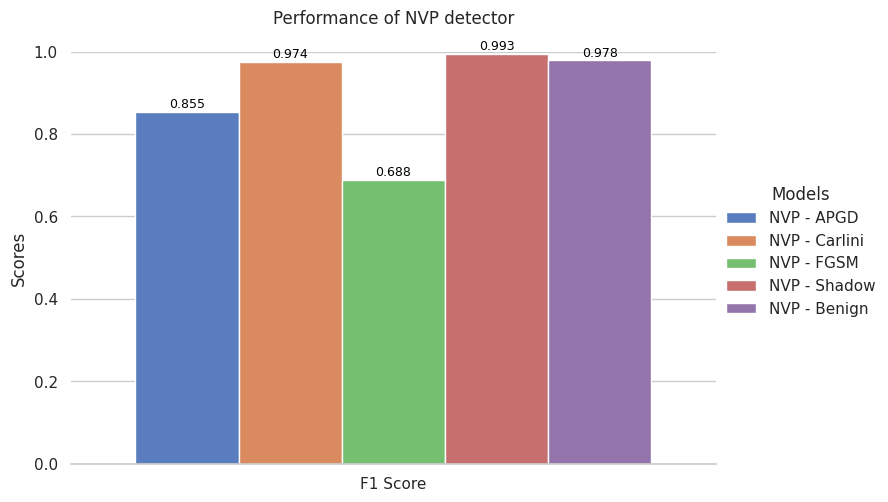

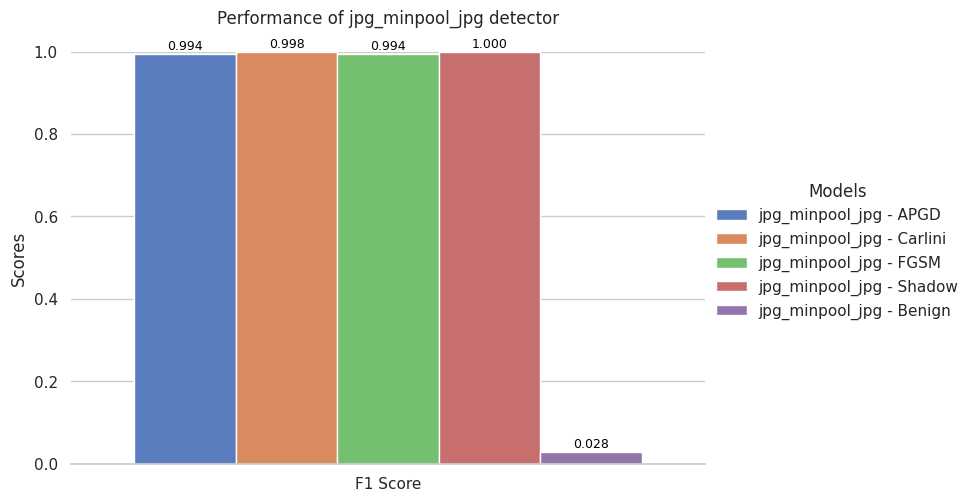

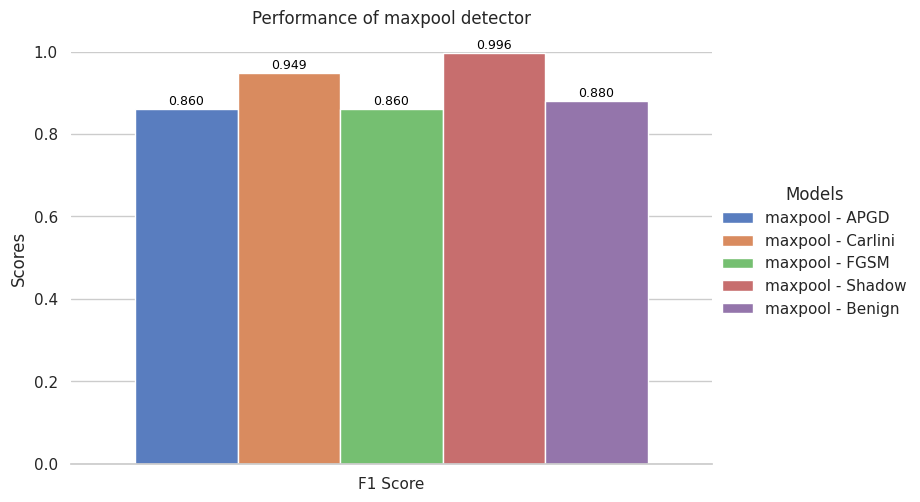

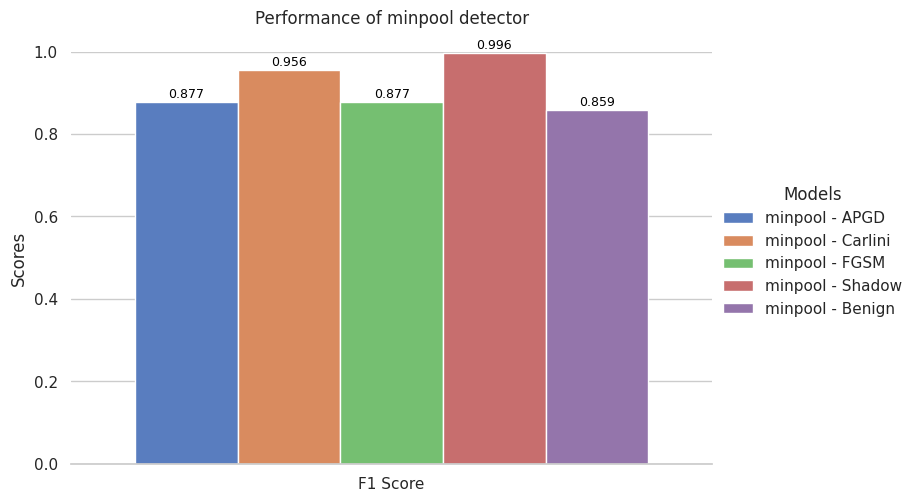

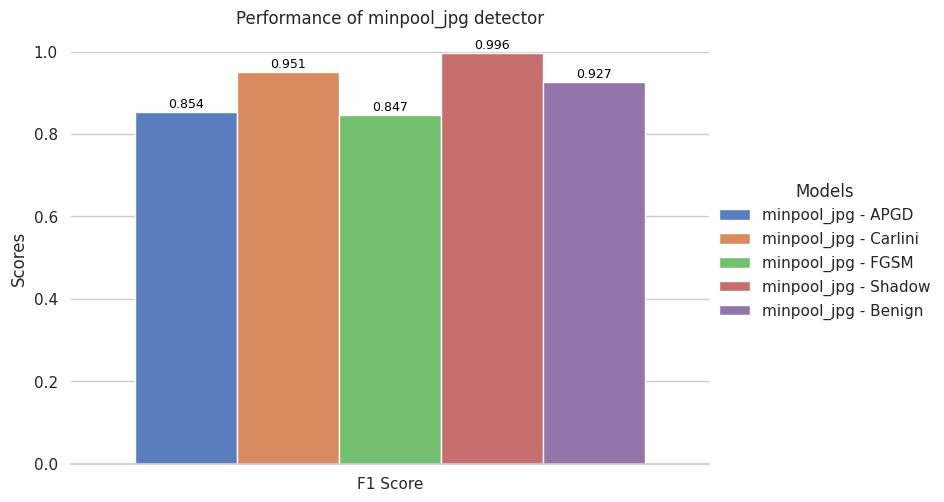

In [11]:


def plot_metrics_nvp_list_metrics(metrics_combined, Bar_str, should_save=False):
    bar_labels = [Bar_str]
    
    merged_metrics = [metrics_combined]

    data = []
    for metric_key in merged_metrics[0].keys():
        for i, d in enumerate(merged_metrics):
            f1_score = d[metric_key]['f1_score']
            data.append({'Models': f'{bar_labels[i]} - {metric_key}', 'Metric': 'F1 Score', 'Value': f1_score})

    df = pd.DataFrame(data)

    sns.set(style="whitegrid")
    g = sns.catplot(x="Metric", y="Value", hue="Models", data=df, kind="bar", palette="muted", height=5, aspect=1.5)
    g.despine(left=True)
    g.set_ylabels("Scores")
    plt.title(f'Performance of {Bar_str} detector', pad=20)
    g.set_xlabels("")

    g.axes.flat[0].set_ylim([0.0,1])

    for ax in g.axes.flat:
        for label in ax.containers:
            for p, rect in zip(label.patches, label.get_children()):
                ax.annotate('{:.3f}'.format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='baseline', fontsize=9, color='black', xytext=(0, 3), textcoords='offset points')
    if should_save:
        plt.savefig(
            f"{project_root}/plots/nvp_attack_type_performance_{Bar_str}_f1.svg",  bbox_inches = 'tight'
        )
        plt.savefig(
            f"{project_root}/plots/nvp_attack_type_performance_{Bar_str}_f1.png",  bbox_inches = 'tight'
        )
    plt.show()

nvp_metrics_1 = calculate_pred_list_metrics(nvp_preds, nvp_threshold)
indiv_metrics = [calculate_pred_list_metrics(x,y) for x,y in zip(nvp_indiv_preds, indiv_thresholds)]


plot_metrics_nvp_list_metrics(nvp_metrics_1,"NVP", should_save=True)
for m,lab in zip(indiv_metrics,list(nvp_functions.keys())):
    plot_metrics_nvp_list_metrics(m,lab, should_save=True)

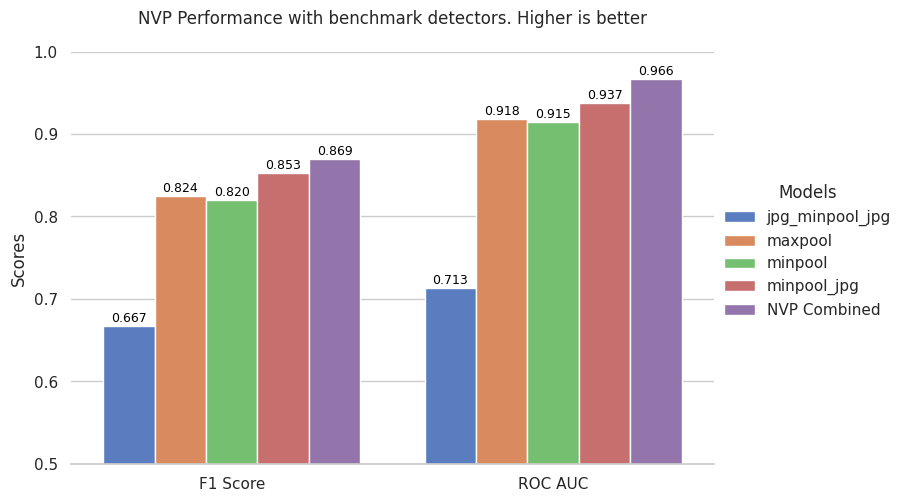

In [12]:
def plot_metrics_nvp(report,individual_metrics, should_save=False):
    combined_metrics = calculate_metrics(report)
    individual_metrics = [calculate_metrics(x) for x in individual_metrics]
    bar_labels = []
    bar_labels.extend([key for key,val in nvp_functions.items()])
    bar_labels.append("NVP Combined")
    merged_metrics = []
    for indiv_metric in individual_metrics:
        merged_metrics.append(indiv_metric)
    merged_metrics.append(combined_metrics)
    
    f1_scores = [d['combined']['f1_score'] for d in merged_metrics]
    roc_aucs = [d['combined']['roc_auc'] for d in merged_metrics]

    data = []
    for i, (f1_score, roc_auc) in enumerate(zip(f1_scores, roc_aucs)):
        data.append({'Models': f'{bar_labels[i]}', 'Metric': 'F1 Score', 'Value': f1_score})
        data.append({'Models': f'{bar_labels[i]}', 'Metric': 'ROC AUC', 'Value': roc_auc})
    
    df = pd.DataFrame(data)

    sns.set(style="whitegrid")
    g = sns.catplot(x="Metric", y="Value", hue="Models", data=df, kind="bar", palette="muted", height=5, aspect=1.5)
    g.despine(left=True)
    g.set_ylabels("Scores")
    plt.title(f'NVP Performance with benchmark detectors. Higher is better', pad=20)
    g.set_xlabels("")
    
    g.axes.flat[0].set_ylim([0.5,1])

    for ax in g.axes.flat:
        for label in ax.containers:
            for p, rect in zip(label.patches, label.get_children()):
                ax.annotate('{:.3f}'.format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='baseline', fontsize=9, color='black', xytext=(0, 3), textcoords='offset points')
    if should_save:
        plt.savefig(
            f"{project_root}/plots/nvp_performance_f1_roc.svg",  bbox_inches = 'tight'
        )
        plt.savefig(
            f"{project_root}/plots/nvp_performance_f1_roc.png",  bbox_inches = 'tight'
        )
    plt.show()

plot_metrics_nvp(report_nvp, indiv_nvp_reports, should_save=True)
